### Plots with the event generator reconstruction

In [1]:
import tables
import numpy as np
import nuflux
import pandas as pd
import math
from scipy import stats, interpolate, integrate
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [3]:
with tables.open_file('evt_gen_tau_sig.hdf5') as f:
    sim_reco = f.root.EventGeneratorSelectedRecoNN_I3Particle.cols[:]
    sim_weight_dict = f.root.I3MCWeightDict.cols[:]
    
with tables.open_file('evt_gen_sig_data.hdf5') as f:
    sig_reco = f.root.EventGeneratorSelectedRecoNN_I3Particle.cols[:]

In [4]:
len(sim_reco)

13765

In [5]:
LIVETIME = 306125311.5

In [6]:
NOMINAL_PHI = 2.04
NOMINAL_GAMMA = 2.62

In [7]:
def astro_weight(weight_dict, phi=NOMINAL_PHI, gamma=NOMINAL_GAMMA, n_files=14834):
    energy = weight_dict['PrimaryNeutrinoEnergy']
    oneweight = weight_dict['OneWeight']
    n_events = weight_dict['NEvents']
    
    en_weights = 1e-18 * phi * (energy / 1e5)**(-gamma)
  
    return en_weights * oneweight / n_files / n_events

In [8]:
sim_weights = astro_weight(sim_weight_dict) * LIVETIME
sim_weights.sum()

5.944364383354687

In [9]:
def build_df(arr):
    df_dict = {k: arr[k] for k in ('x', 'y', 'z', 'energy', 'azimuth')}
    df_dict['coszen'] = np.cos(arr['zenith'])
    
    df_dict['energy'] /= 1000
    
    return pd.DataFrame(df_dict)

In [10]:
sim = build_df(sim_reco)
sim['weight'] = sim_weights
sim.head()

,x,y,z,energy,azimuth,coszen,weight
0,279.268678,351.237552,-363.600966,25.060985,1.136546,0.436689,0.000198
1,180.408205,-452.077415,-464.609293,341.172046,4.389629,0.675242,0.000505
2,282.739974,193.623210,392.837122,109.284233,5.983281,0.516898,0.000234
3,163.107555,188.024219,-321.431997,24.498184,5.004611,0.760927,0.000725
4,-168.707715,427.587043,-252.928873,177.803969,4.211178,0.920343,0.000228


In [11]:
data = build_df(sig_reco)
data

,x,y,z,energy,azimuth,coszen
0,-463.227410,70.865015,-24.146679,114.207950,2.141168,0.395427
1,142.104930,-484.059222,-165.650283,71.765497,2.236474,0.963237
2,496.431003,229.805933,16.956509,65.869698,0.903512,0.594682
3,308.019468,-209.976170,60.423382,81.862560,6.078405,0.450099
4,-156.968781,-168.633054,-206.735850,89.938275,5.536058,-0.595635
5,565.152976,160.615836,-170.051387,23.796537,6.236886,0.459059
6,-75.751186,262.846522,27.846949,1083.823432,5.168700,0.876975


### Calculate Hull distances

In [12]:
import json
with open('position_map.json') as f:
    pos_df = pd.DataFrame(json.load(f))
pos_df = pd.DataFrame(pos_df[pos_df.z < 1500])
string_df = pos_df.groupby('string').mean()

In [13]:
from scipy.spatial import ConvexHull
string_points = string_df[['x', 'y']].to_numpy()
hull = ConvexHull(string_points)
hull_segs = string_points[hull.simplices]

In [14]:
def pt_to_segment(seg, pt):    
    d_to_point = pt - seg[0]
    d_to_point_norm = np.linalg.norm(d_to_point)
    seg_vec = seg[1] - seg[0]
    seg_vec_norm = np.linalg.norm(seg_vec)
    costheta = (seg_vec @ d_to_point) / seg_vec_norm / d_to_point_norm
    
    min_dist = d_to_point_norm * np.sqrt(1 - costheta**2)
    
    dist_along_seg = d_to_point_norm * costheta
    pt_on_seg = 0 <= dist_along_seg <= seg_vec_norm
    connector_pt = seg[0] + seg_vec * dist_along_seg / seg_vec_norm
    
    return min_dist, connector_pt, pt_on_seg


def min_dist_to_hull(hull_segs, pt, check_pt=False):
    min_dist, connector, on_seg = min((pt_to_segment(seg, pt) for seg in hull_segs), 
                                      key=lambda tup: tup[0])    
    if check_pt and not on_seg:
        raise ValueError('Connector point is not on the line segment!')
        
    return min_dist, connector

In [15]:
for df in data, sim:
    df['hull_dist'] = [min_dist_to_hull(hull_segs, pt)[0] for pt in df[['x', 'y']].to_numpy()]

(-600.0, 600.0)

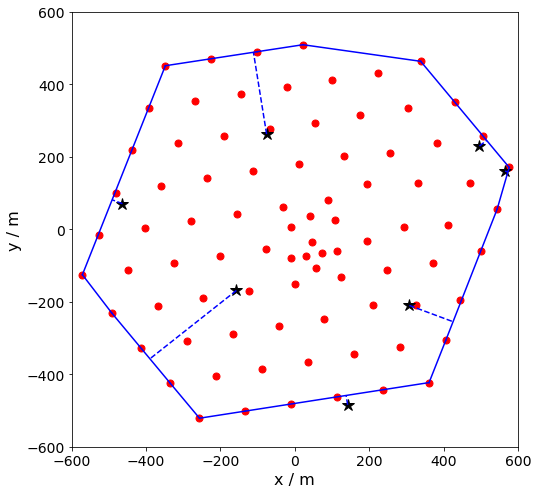

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlabel('x / m')
ax.set_ylabel('y / m')

ax.plot(string_df.x, string_df.y, 'ro', markersize=7)

ax.plot(data['x'], data['y'], 'k*', markersize=12)

for seg in hull_segs:
    plt.plot(*seg.T, 'b-')

min_dists = []
for _, pt in data.iterrows():
    pt = np.array([pt['x'], pt['y']])
    min_dist, connector_pt = min_dist_to_hull(hull_segs, pt)
    min_dists.append(min_dist)
    
    ax.plot(*np.vstack((pt, connector_pt)).T, 'b--')
    
min_dists = np.array(min_dists)

ax.set_xlim(-600, 600)
ax.set_ylim(-600, 600)

In [17]:
def data_mc_hist_1d(feature, bins, logx=False, logy=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    hist = np.histogram(sim[feature], bins=bins, weights=sim['weight'])[0]

    ax.step(bins, np.hstack([hist, [0]]), where='post', label='signal expectation')

    for i, en in enumerate(data[feature]):
        label = None if i != 0 else 'data'
        ax.axvline(en, ymax=0.4, color='black', label=label)

    ax.set_xlabel(f'event generator {feature}') 
    ax.set_ylabel('number of expected events')

    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.legend()
    
    return fig, ax

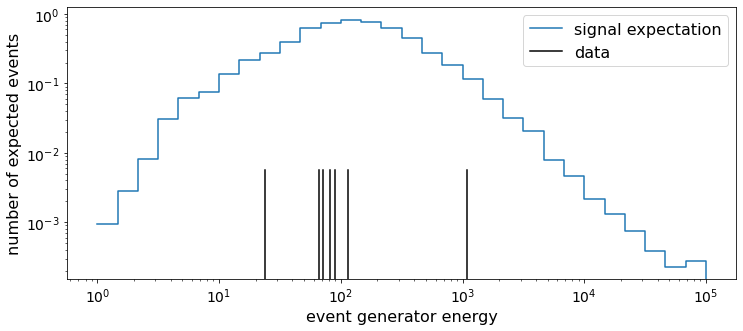

In [18]:
bins = np.logspace(0, 5, 31)
fig, ax = data_mc_hist_1d('energy', bins, True, True)

In [19]:
p = stats.poisson(sim[sim.energy < 100].weight.sum())
1 - sum(p.pmf(i) for i in range(len(data[data.energy < 100])))

0.11752951693214664

(-1.0, 1.0)

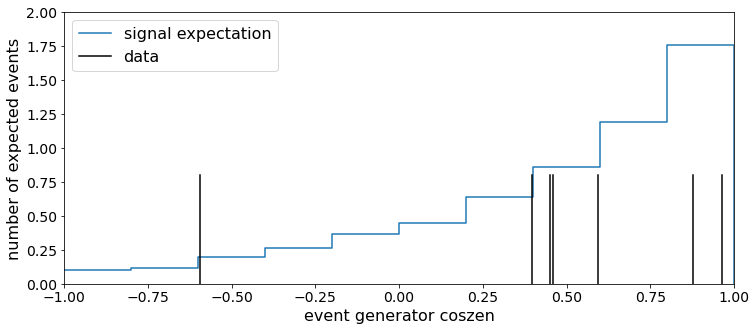

In [20]:
bins = np.linspace(-1, 1, 11)
fig, ax = data_mc_hist_1d('coszen', bins)

ax.set_ylim(0, 2.0)
ax.set_xlim(-1, 1)

### coszen, z 2d histogram

In [21]:
def poisson_llh(hist, exp):
    nonempty_mask = exp > 0
    exp = exp[nonempty_mask]
    hist = hist[nonempty_mask]
    
    return (hist * np.log(exp) - exp).sum() 


def poisson_gof(hist, exp):
    saturated = np.zeros(hist.shape)
    non_empty_mask = hist > 0
    non_empty_hist = hist[non_empty_mask]
    saturated[non_empty_mask] = non_empty_hist * np.log(non_empty_hist) - non_empty_hist
        
    return -2*(poisson_llh(hist, exp) - saturated.sum())


def conduct_trial(exp):
    data_hist = rng.poisson(lam=exp)
    return poisson_gof(data_hist, exp)


n_trials = 100000
rng = np.random.default_rng()

In [22]:
def hist2d_plot(x, y, x_bins, y_bins, logx=False, logy=False):
    fig, ax = plt.subplots(figsize=(8, 8))

    mc_hist = np.histogram2d(sim[x], sim[y], bins=(x_bins, y_bins), weights=sim.weight)[0].T

    m = ax.pcolormesh(x_bins, y_bins, mc_hist, rasterized='True', cmap='Blues')

    c = plt.colorbar(m)
    c.ax.set_ylabel('number of expected events')

    ax.set_xlabel(x)
    ax.set_ylabel(y)

    ax.plot(data[x], data[y], 'k*', markersize=12)
    
    data_hist =  np.histogram2d(data[x], data[y], bins=(x_bins, y_bins))[0].T
    
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
        
    return mc_hist, data_hist

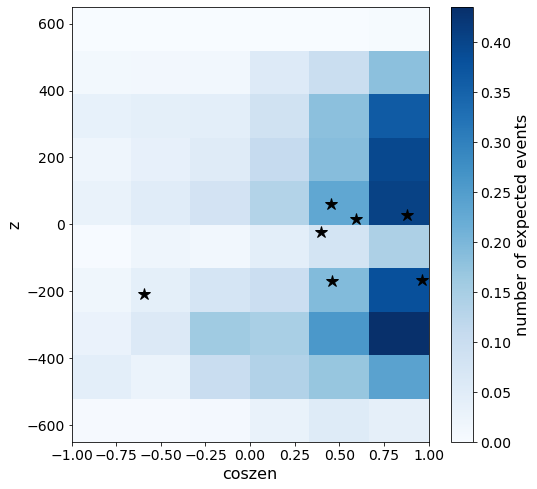

In [23]:
coszen_bins = np.linspace(-1, 1, 7)
z_bins = np.linspace(-650, 650, 11)
mc_hist, data_hist = hist2d_plot('coszen', 'z', coszen_bins, z_bins)

In [24]:
def gof_plot(trial_gofs, mc_hist, data_hist):
    fig, ax = plt.subplots(figsize=(12, 5))
    bins = np.linspace(0, 50, 100)
    hist = np.histogram(trial_gofs, bins=bins, density=True)[0]
    ax.step(bins[:-1], hist, where='post', label='pseudotrials')
    ax.set_xlabel('goodness of fit')
    ax.set_ylabel('density')

    observed_gof = poisson_gof(data_hist, mc_hist)
    
    ax.axvline(observed_gof, color='k', linestyle='--', label='observed')

    p_val = len(trial_gofs[trial_gofs >= observed_gof]) / len(trial_gofs)

    ax.legend()
    ax.set_title(f'{mc_hist.size} bins, p value = {p_val:.3f}')

In [25]:
gofs = np.array([conduct_trial(mc_hist) for _ in range(n_trials)])

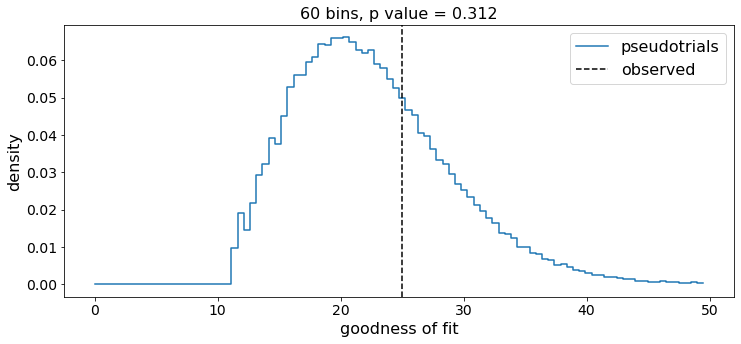

In [26]:
gof_plot(gofs, mc_hist, data_hist)

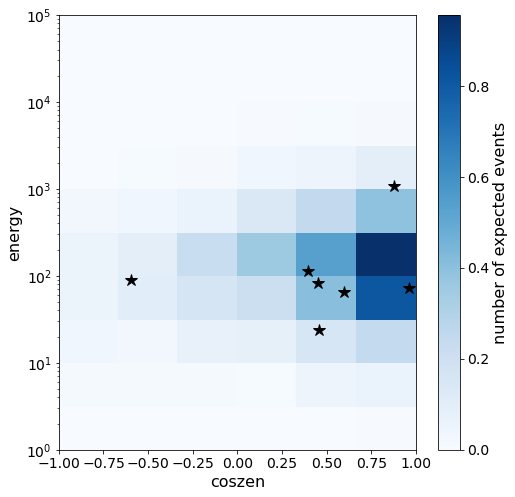

In [27]:
coszen_bins = np.linspace(-1, 1, 7)
en_bins = np.logspace(0, 5, 11)
mc_hist, data_hist = hist2d_plot('coszen', 'energy', coszen_bins, en_bins, logy=True)

In [28]:
en_coszen_gofs = np.array([conduct_trial(mc_hist) for _ in range(n_trials)])

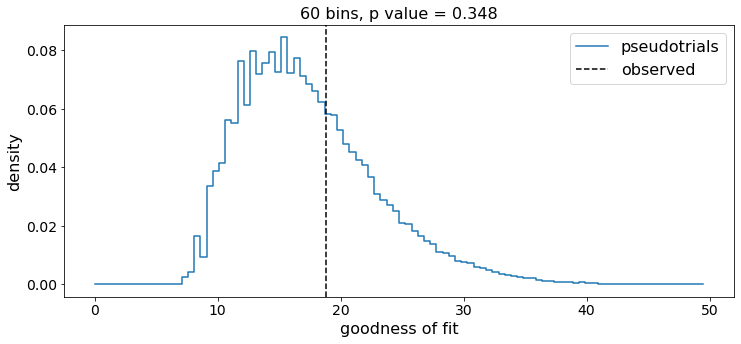

In [29]:
gof_plot(en_coszen_gofs, mc_hist, data_hist)

(0.0, 331.67184270002525)

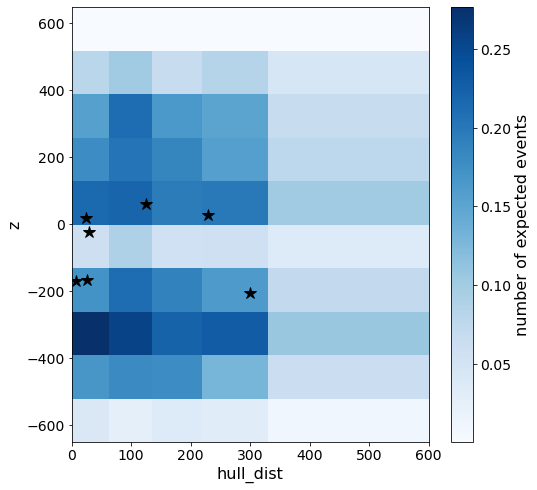

In [30]:
hull_bins = np.sort(600 - np.sqrt(np.linspace(0, 600**2, 6)))
z_bins = np.linspace(-650, 650, 11)
mc_hist, data_hist = hist2d_plot('hull_dist', 'z', hull_bins, z_bins)
ax.set_xlim(0, hull_bins[-2])

In [31]:
hull_z_gofs = np.array([conduct_trial(mc_hist) for _ in range(n_trials)])

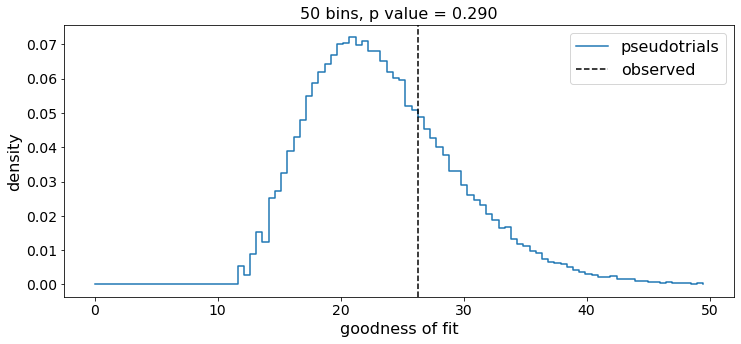

In [32]:
gof_plot(hull_z_gofs, mc_hist, data_hist)

# KS tests

In [33]:
def ks_test(var, bins, data=data, logx=False, logy=False):
    hist = np.histogram(sim[var], bins=bins, weights=sim.weight, density=True)[0]
    cdf = integrate.cumtrapz(hist, bins[1:], initial=0)

    fig, ax = plt.subplots(figsize=(12,5))
    ax.step(bins, np.hstack([cdf, [1]]), where='post', label='CDF of weighted MC')

    interp_cdf = interpolate.interp1d(bins[1:], cdf, kind='cubic', fill_value=(0, 1), bounds_error=False)
    if logx:
        interp_pts = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), 101)
    else:    
        interp_pts = np.linspace(bins[0], bins[-1] + bins[1] - bins[0], 101)
    ax.plot(interp_pts, interp_cdf(interp_pts), 'k--', label='continuous interpolation')

    ax.set_title(f'{stats.kstest(data[var], interp_cdf)}')
    
    ax.set_xlabel(var)
    ax.set_ylabel(f'CDF({var})')
    
    for i, row in data.iterrows():
        label = 'data' if i == 0 else None
        ax.axvline(row[var], ymax=0.4, color='r', label=label)
        
    if logx:
        ax.set_xscale('log')
    
    if logy:
        ax.set_yscale('log')
        
    ax.legend()

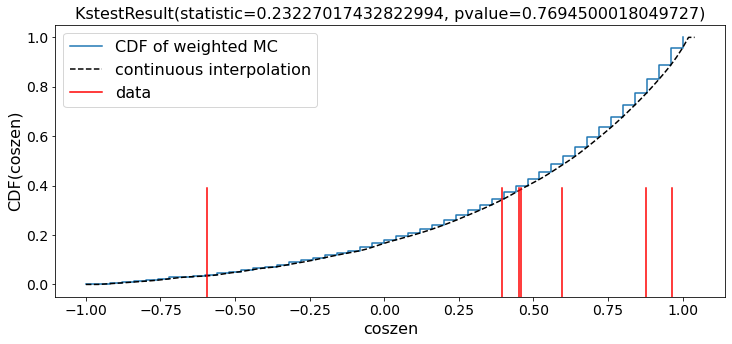

In [34]:
ks_test('coszen', np.linspace(-1, 1, 51))

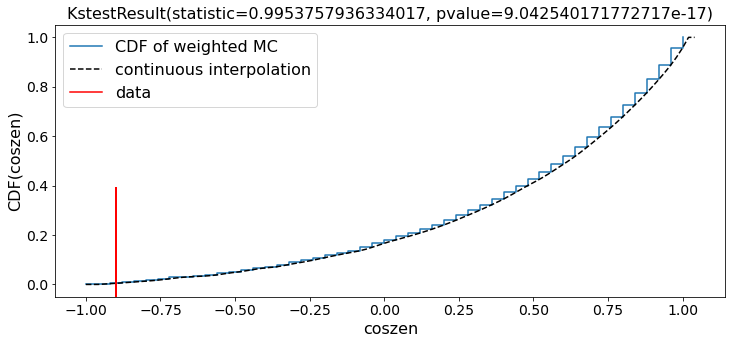

In [35]:
fake_data = data.copy()
fake_data['coszen'] = -0.9
ks_test('coszen', np.linspace(-1, 1, 51), data=fake_data, )

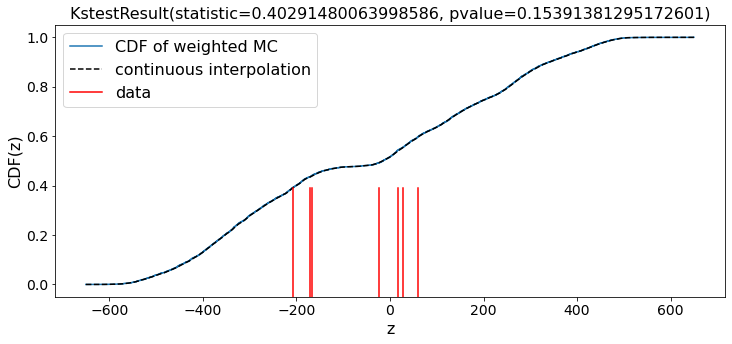

In [36]:
ks_test('z', np.linspace(-650, 650, 1001))

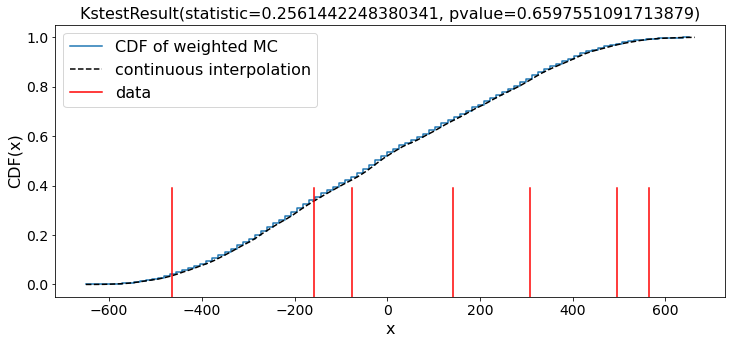

In [37]:
ks_test('x', np.linspace(-650, 650, 101))

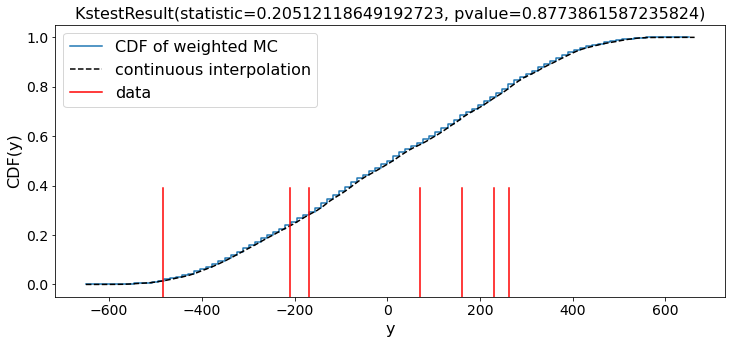

In [38]:
ks_test('y', np.linspace(-650, 650, 101))

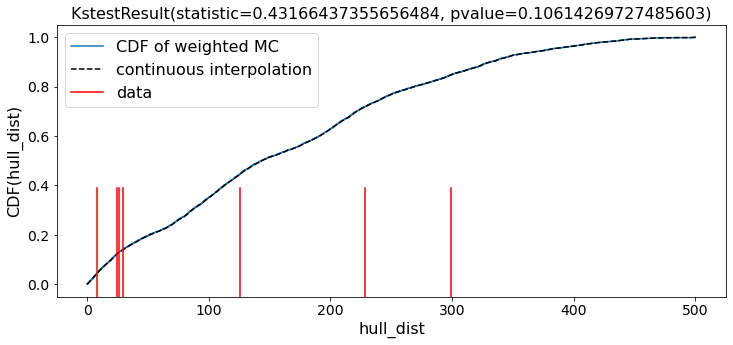

In [39]:
ks_test('hull_dist', np.linspace(0, 500, 1001))

(1, 99000.0)

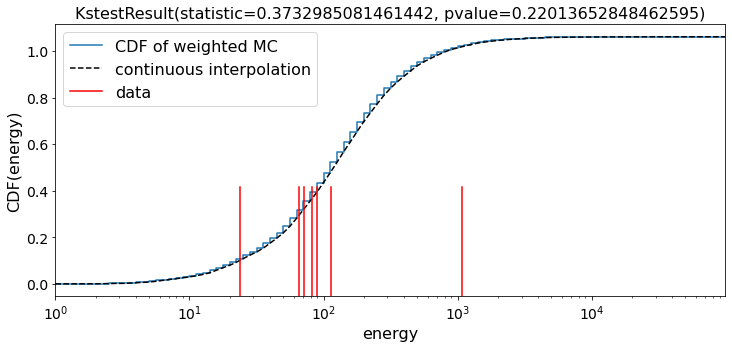

In [40]:
ks_test('energy', np.logspace(0, 5, 101), logx=True)
plt.gca().set_xlim(1, 1e5-1000)

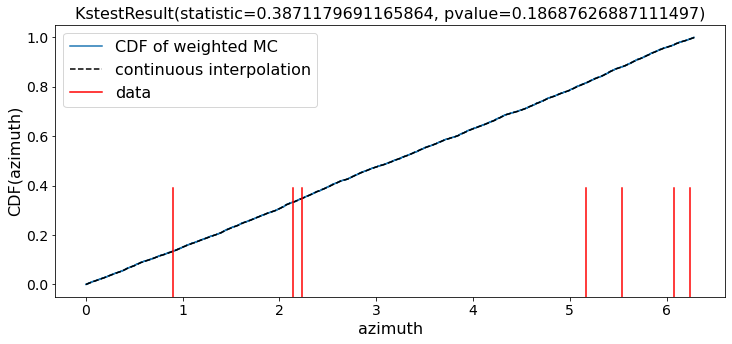

In [41]:
ks_test('azimuth', np.linspace(0, 2*np.pi, 1001))

Try two sample version following 
https://stats.stackexchange.com/questions/193439/two-sample-kolmogorov-smirnov-test-with-weights

In [42]:
sim_sample_size = (sim.weight.sum())**2/(sim.weight**2).sum()
sim_sample_size

4738.45073088486

In [43]:
ndf = round(sim_sample_size*len(data)/(len(data) + sim_sample_size))
ks_dist = stats.kstwo(ndf)

In [44]:
# see https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/stats.py#L7319-L7493
# https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
def weighted_two_sample(varname, data, sim, dist=ks_dist, ndf=ndf):
    sim_inds = np.argsort(sim[varname])
    sim_weights = sim.weight[sim_inds].to_numpy()
    sim_var = sim[varname][sim_inds].to_numpy()
    data_var = np.sort(data[varname].to_numpy())
    
    sim_cdf = np.hstack([0, sim_weights.cumsum()]) / sim_weights.sum()
    
    all_data = np.hstack([data_var, sim_var])
    
    data_cdf = np.searchsorted(data_var, all_data, side='right') / len(data)
    sim_cdf = sim_cdf[np.searchsorted(sim_var, all_data, side='right')]

    abs_diffs = np.abs(sim_cdf - data_cdf)
    max_ind = np.argmax(abs_diffs)
    d = abs_diffs[max_ind]
    
    if max_ind < len(data_var):
        max_v = data_var[max_ind]
    else:
        max_v = sim_var[max_ind - len(data_var)]
    
    
    # note: also tried using stats.stats._attempt_exact_2kssamp 
    # (https://github.com/scipy/scipy/blob/47bb6febaa10658c72962b9615d5d5aa2513fa3a/scipy/stats/stats.py#L7272)  
    # it gives practically identical results to the asymptotic treatment employed here
    
    return stats.stats.KstestResult(d, dist.sf(d)), max_v

In [45]:
weighted_two_sample('x', data, sim)

(KstestResult(statistic=0.26370485954074585, pvalue=0.6243472265323369),
 308.01843947786114)

In [46]:
results = []
varnames = ('coszen', 'azimuth', 'x', 'y', 'z', 'energy', 'hull_dist')
for var in varnames:
    test_res = weighted_two_sample(var, data, sim)
    print(f'{var}: {test_res[0].pvalue}')
    results.append(test_res)

coszen: 0.8441377940222082
azimuth: 0.18508750057972612
x: 0.6243472265323369
y: 0.9093637097189705
z: 0.1566006785512929
energy: 0.20247774203998836
hull_dist: 0.11141129579901898


In [47]:
def ks_2samp_plot(data, sim, varname, ksresult):
    data = np.sort(data[varname])
    
    sim_var = sim[varname]
    sim_weights = sim.weight
    sim_inds = np.argsort(sim_var)
    sim_var = sim_var[sim_inds]
    sim_weights = sim_weights[sim_inds]
    
    sim_cdf = np.hstack([0, sim_weights.cumsum()]) / sim_weights.sum()
    
    if varname != 'energy':
        xs = np.linspace(sim_var.min(), sim_var.max(), 10000)
    else:
        xs = np.logspace(np.log10(sim_var.min()), np.log10(sim_var.max()), 10000)
    data_y = np.searchsorted(data, xs, side='left') / len(data)
    
    sim_y = sim_cdf[np.searchsorted(sim_var, xs, side='left')]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(xs, data_y, label='data')
    ax.plot(xs, sim_y, label='weighted MC')
    
    ax.legend()
    ax.set_title(ksresult[0])
    
    max_v = ksresult[1]
    ind = np.argwhere(xs < max_v)[-1][0]

    
    if data_y[ind] < sim_y[ind]:
        low = data_y[ind]
        high = data_y[ind] + ksresult[0].statistic
    else:
        low = sim_y[ind]
        high = sim_y[ind] + ksresult[0].statistic
        
    ax.plot([max_v, max_v], [low, high], 'r-', linewidth=3)
    
    ax.axhline(low, color='k', linestyle='--')
    ax.axhline(high, color='k', linestyle='--')
    
    ax.set_xlabel(varname)
    ax.set_ylabel(f'CDF({varname})')
    
    return fig, ax

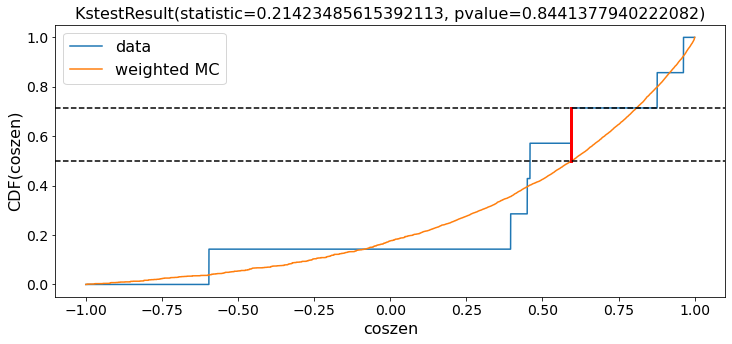

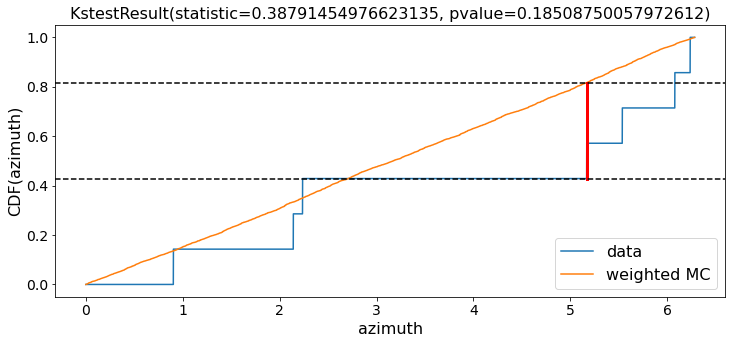

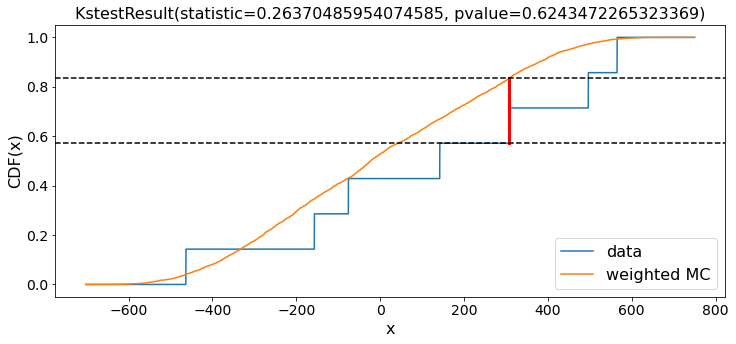

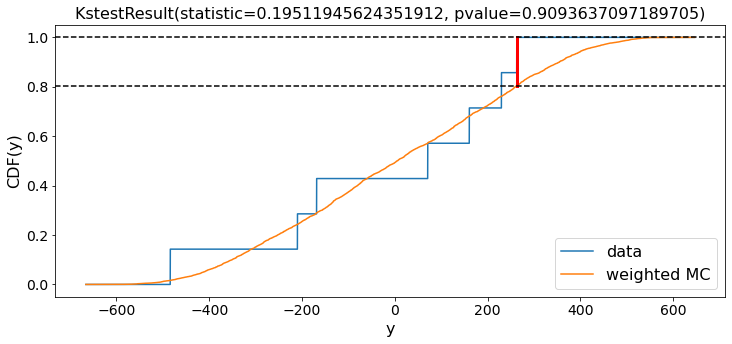

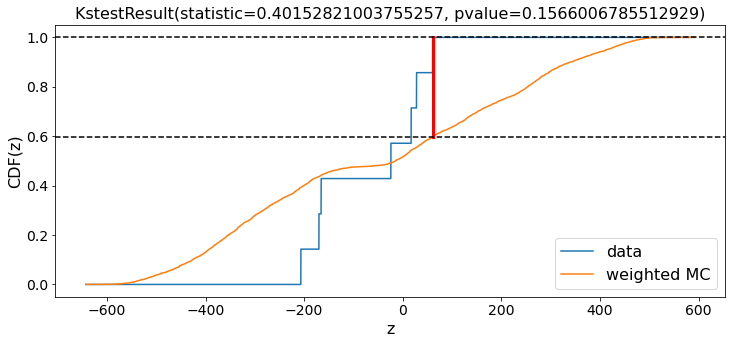

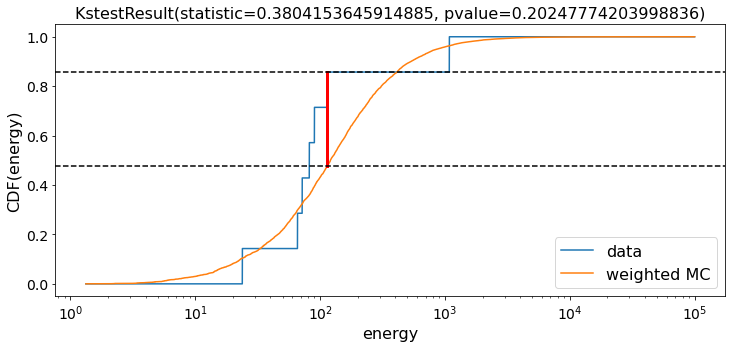

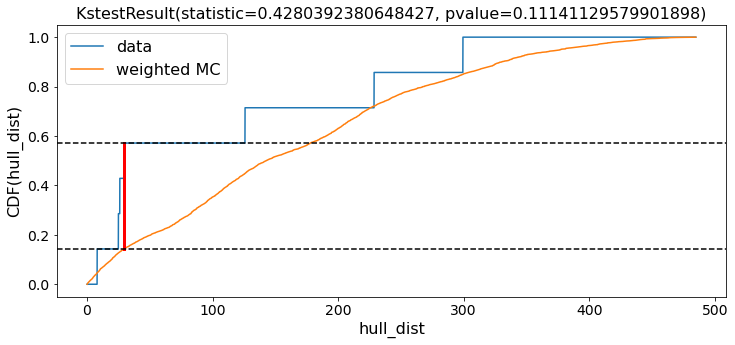

In [48]:
for varname, result in zip(varnames, results):
    fig, ax = ks_2samp_plot(data, sim, varname, result)
    if varname == 'energy':
        ax.set_xscale('log')

Text(0.5, 1.0, 'Event generator reco')

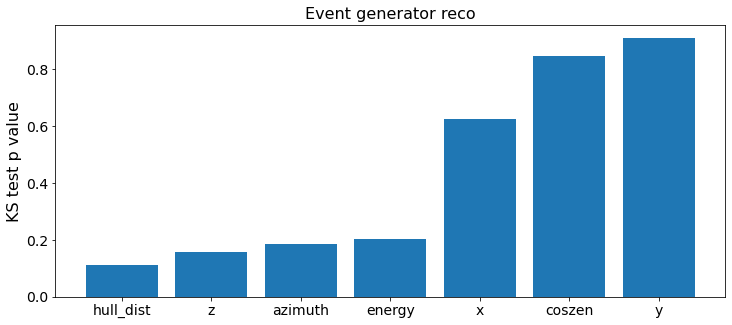

In [49]:
fig, ax = plt.subplots(figsize=(12,5))
p_vals = np.array([result[0].pvalue for result in results])
order = np.argsort(p_vals)
sorted_varnames = [varnames[i] for i in order]
ax.bar(sorted_varnames, p_vals[order]) 
ax.set_ylabel('KS test p value')
ax.set_title('Event generator reco')

### Some probabilities:

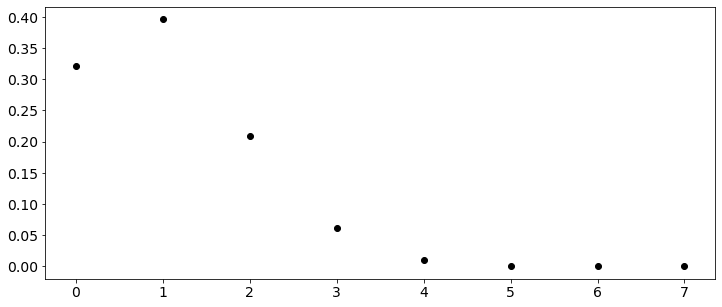

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))
binom = stats.binom(7, 0.15)

n_successes = np.arange(8)
ax.plot(n_successes, binom.pmf(n_successes), 'ko')